In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Main and side hustle

In [20]:
product_df = pd.read_csv('data/products.csv')

In [22]:
data_categories = ["Digital Commerce", "Digital Security", "Digital Knowledge Products", "Other Digital Products"]
drug_categories = ["Recreational Drugs", "Pharmaceutical Drugs"]

In [23]:
# Create a new column to identify vendors with a main business in data or drugs
product_df['main_business'] = product_df['broad_category'].apply(lambda x: 'Data' if x in data_categories else ('Drug' if x in drug_categories else 'Other'))

In [24]:
# Count the number of vendors with data and drug as their main business
product_main_count = product_df['vendor'].groupby(product_df['main_business']).nunique()

In [25]:
# To find side hustles, we need to see if vendors listed under 'Data' also sell under 'Drug' and vice versa
# Create a pivot table of vendors by their categories
vendor_category_pivot = pd.crosstab(product_df['vendor'], product_df['broad_category'])

In [26]:
# Check if a vendor sells both data and drug related products
vendor_category_pivot['Data'] = vendor_category_pivot[data_categories].sum(axis=1) > 0
vendor_category_pivot['Drug'] = vendor_category_pivot[drug_categories].sum(axis=1) > 0

In [27]:
# Count vendors who are involved in both data and drug as a side business
side_business_count = vendor_category_pivot[(vendor_category_pivot['Data'] == True) & (vendor_category_pivot['Drug'] == True)].shape[0]

product_main_count, side_business_count

(main_business
 Data    157
 Drug    355
 Name: vendor, dtype: int64,
 69)

In [28]:
# Calculate the percentages for side businesses
total_data_vendors = product_main_count['Data']
total_drug_vendors = product_main_count['Drug']
percentage_data_side_hustle = (side_business_count / total_data_vendors) * 100
percentage_drug_side_hustle = (side_business_count / total_drug_vendors) * 100

# Create print statements for the statistics
print_statements = {
    "Total Data Vendors": f"Total vendors primarily dealing with data-related products: {total_data_vendors}",
    "Total Drug Vendors": f"Total vendors primarily dealing with drug-related products: {total_drug_vendors}",
    "Total Side Business Vendors": f"Total vendors with side businesses in both domains: {side_business_count}",
    "Percentage Data Side Business": f"Percentage of data-related vendors with a side business in drugs: {percentage_data_side_hustle:.2f}%",
    "Percentage Drug Side Business": f"Percentage of drug-related vendors with a side business in data: {percentage_drug_side_hustle:.2f}%"
}

print_statements

{'Total Data Vendors': 'Total vendors primarily dealing with data-related products: 157',
 'Total Drug Vendors': 'Total vendors primarily dealing with drug-related products: 355',
 'Total Side Business Vendors': 'Total vendors with side businesses in both domains: 69',
 'Percentage Data Side Business': 'Percentage of data-related vendors with a side business in drugs: 43.95%',
 'Percentage Drug Side Business': 'Percentage of drug-related vendors with a side business in data: 19.44%'}

## Plots
- Digital Commerce: Counterfeit Items, Fraud, Services
- Digital Security: Hacking and Cybersecurity, Software & Hosting
- Digital Knowledge Products: E-Books, Guides & Tutorials
- Recreational Drugs: Cannabis & Hash, Psychedelics, Stimulants, Ecstasy, Dissociatives
- Pharmaceutical Drugs: Benzos, Opioids, Prescriptions, Steroids
- Other Digital Products: Accounts, Others

In [29]:
product_count_broad = product_df['broad_category'].value_counts()
vendor_activity = product_df.groupby(['vendor', 'broad_category']).size().unstack(fill_value=0)

In [45]:
# Bar Chart for Product Count by Broad Category
plt.figure(figsize=(10, 6))
sns.barplot(x=product_count_broad.index, y=product_count_broad.values, palette="viridis")
plt.title('Product Count by Broad Category')
plt.ylabel('Number of Products')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

/var/folders/z0/r3f28d6574z4sy1kjhxmryhm0000gn/T/ipykernel_9212/4084200098.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_count_broad.index, y=product_count_broad.values, palette="viridis")


In [46]:
# Summing up the total products per vendor and sorting
vendor_activity['Total Products'] = vendor_activity.sum(axis=1)
sorted_vendors = vendor_activity.sort_values(by='Total Products', ascending=False).head(20)

# Heatmap for Top 20 Vendors by Activity
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(sorted_vendors.drop('Total Products', axis=1), annot=True, fmt="d", cmap="viridis", linewidths=.5)
# Set title and labels with white color
plt.title('Vendor Activity for Top 20 Vendors', color='white')
plt.ylabel('Vendor', color='white')
plt.xlabel('Broad Category', color='white')

# Change tick colors to white
plt.xticks(color='white')
plt.yticks(color='white')

# Change background color to #121212
plt.gca().patch.set_facecolor('#121212')

# Adjust colorbar text and ticks to white
cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Use tight layout to adjust the plot dimensions dynamically
plt.tight_layout()

# Save as PNG with specified background color and ensure the text color is maintained
plt.savefig('assets/vendor_activity.png', facecolor='#121212', edgecolor='none')
plt.show()

In [47]:
# Histogram to show the distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(product_df['price_usd'], bins=50, color='blue', kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.xscale('log')  # Using log scale due to wide range of prices
plt.grid(True)
plt.show()

In [48]:
# remove 'Digital Package' and 'Physical Package' from the category column, fill with None
# these categories are too broad and do not provide useful information
# we predicted the categories ourselves with a model for the broad categories
product_df['category'] = product_df['category'].apply(lambda x: x if x not in ['Digital Package', 'Physical Package'] else None)

In [49]:
# Extracting top categories within Data-Related and Drug-Related products
top_data_categories = product_df[product_df['main_business'] == 'Data']['category'].value_counts().head(5)
top_drug_categories = product_df[product_df['main_business'] == 'Drug']['category'].value_counts().head(5)

# Creating pie charts for top categories
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].pie(top_data_categories.values, labels=top_data_categories.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', 5))
ax[0].set_title('Top 5 Categories in Data-Related Products')

ax[1].pie(top_drug_categories.values, labels=top_drug_categories.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('magma', 5))
ax[1].set_title('Top 5 Categories in Drug-Related Products')

plt.tight_layout()
plt.show()

In [50]:
# Calculating average price by broad category
average_price_broad = product_df.groupby('broad_category')['price_usd'].mean()

# Bar chart for average price comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=average_price_broad.index, y=average_price_broad.values, palette="coolwarm")
plt.title('Average Price by Broad Category')
plt.ylabel('Average Price (USD)')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.show()

/var/folders/z0/r3f28d6574z4sy1kjhxmryhm0000gn/T/ipykernel_9212/1895186874.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_price_broad.index, y=average_price_broad.values, palette="coolwarm")


In [51]:
# change drug to drugs in main_business column
product_df['main_business'] = product_df['main_business'].apply(lambda x: 'Drugs' if x == 'Drug' else x)

In [53]:
product_df[['name', 'main_business', 'vendor', 'category', 'price_usd', 'broad_category']].to_csv('data/product_vendor.csv', index=False)

In [55]:
# Categorizing prices into ranges
price_bins = [0, 50, 200, float('inf')]
price_labels = ['Budget (<= $50)', 'Mid-range ($50-$200)', 'High-end (>$200)']
product_df['price_range'] = pd.cut(product_df['price_usd'], bins=price_bins, labels=price_labels, right=False)

# Count of products in each price range
price_range_count = product_df['price_range'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=price_range_count.index, y=price_range_count.values, palette="spring")
plt.title('Product Count by Price Range')
plt.ylabel('Number of Products')
plt.xlabel('Price Range')
plt.show()

price_range_count

/var/folders/z0/r3f28d6574z4sy1kjhxmryhm0000gn/T/ipykernel_9212/309118012.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_range_count.index, y=price_range_count.values, palette="spring")


price_range
Budget (<= $50)         4238
Mid-range ($50-$200)    2011
High-end (>$200)        1739
Name: count, dtype: int64

In [64]:
grouped_products = product_df.groupby(['main_business', 'broad_category', 'price_range']).size().reset_index(name='product_count')
# drop rows with product_count = 0
grouped_products = grouped_products[grouped_products['product_count'] > 0]
grouped_products.rename(columns={'broad_category': 'category'}, inplace=True)
grouped_products.to_csv('data/products_grouped.csv', index=False)

/var/folders/z0/r3f28d6574z4sy1kjhxmryhm0000gn/T/ipykernel_9212/2316051064.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_products = product_df.groupby(['main_business', 'broad_category', 'price_range']).size().reset_index(name='product_count')


In [61]:
product_df

name  \
0     I will teach you Defi flash loan attack method...   
1        15 PROFESSIONAL CARDERS CARDING TIPS TO FOLLOW   
2                                       WEED PINK ROSAY   
3                          Zopiclone 7.5mg x 56 Tablets   
4     1g * High Quality (Racemic) Ketamine No Dissap...   
...                                                 ...   
7983  3.5G HF Cocaine HCL - FTIR Tested Clean - Sing...   
7984                           1000 ICE SPEED BARS 40MG   
7985               7g High Heat Un-Cut Colombia Cocaine   
7986  Riverbell Casino Freshly Hacked DB 250K entrie...   
7987                                  thesource account   

                               category  price_usd  \
0     Digital Guides & Tutorials Fraud       55.00   
1             Digital Services Carding       18.00   
2       Cannabis & Hash Buds & Flowers       32.20   
3                         Benzos Pills       56.16   
4               Dissociatives Ketamine      111.94   
...                                 ...        ...   
7983                               None     137.72   
7984                               None     497.32   
7985                               None     621.27   
7986                               None     918.14   
7987                               None       2.30   

                                            description         vendor  \
0     This listing is all about the business of frau...        cashapp   
1     15 PROFESSIONAL CARDERS CARDING TIPS TO FOLLOW...       BadBreed   
2     Salut tout le monde !!\n\nC'est la TEAM-FRENCH...    FRENCHCANNA   
3     Boxed Pharmacy grade Zopiclone 7.5mg x 56 Tablets       PharmaUK   
4     Youll enjoy your High Quality (Racemic) Ketami...     RockToDoor   
...                                                 ...            ...   
7983  Here at HeadFuzzies we have very stringent qua...    headfuzzies   
7984  ðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’ŠðŸ’Š\nIce bars speed ** Really str...         xancan   
7985  High quality fishscale cocaine. Our review sho...  canadagoodies   
7986  Riverbelle Casino Canada Obtained less than 30...      goatchick   
7987  TheSource is a Canadian electronics retailer o...      modestyv3   

     marketplace                  category_cleaned  \
0          nexus  Digital Guides & Tutorials Fraud   
1          nexus          Digital Services Carding   
2          nexus    Cannabis & Hash Buds & Flowers   
3          nexus                      Benzos Pills   
4          nexus            Dissociatives Ketamine   
...          ...                               ...   
7983  WeTheNorth                  Physical Package   
7984  WeTheNorth                  Physical Package   
7985  WeTheNorth                  Physical Package   
7986  WeTheNorth                   Digital Package   
7987  WeTheNorth                   Digital Package   

                  broad_category main_business           price_range  
0     Digital Knowledge Products          Data  Mid-range ($50-$200)  
1               Digital Commerce          Data       Budget (<= $50)  
2             Recreational Drugs         Drugs       Budget (<= $50)  
3           Pharmaceutical Drugs         Drugs  Mid-range ($50-$200)  
4             Recreational Drugs         Drugs  Mid-range ($50-$200)  
...                          ...           ...                   ...  
7983          Recreational Drugs         Drugs  Mid-range ($50-$200)  
7984          Recreational Drugs         Drugs      High-end (>$200)  
7985          Recreational Drugs         Drugs      High-end (>$200)  
7986            Digital Commerce          Data      High-end (>$200)  
7987            Digital Commerce          Data       Budget (<= $50)  

[7988 rows x 10 columns]

In [63]:
grouped_products

main_business              broad_category           price_range  \
0           Data            Digital Commerce       Budget (<= $50)   
1           Data            Digital Commerce  Mid-range ($50-$200)   
2           Data            Digital Commerce      High-end (>$200)   
3           Data  Digital Knowledge Products       Budget (<= $50)   
4           Data  Digital Knowledge Products  Mid-range ($50-$200)   
5           Data  Digital Knowledge Products      High-end (>$200)   
6           Data            Digital Security       Budget (<= $50)   
7           Data            Digital Security  Mid-range ($50-$200)   
8           Data            Digital Security      High-end (>$200)   
9           Data      Other Digital Products       Budget (<= $50)   
10          Data      Other Digital Products  Mid-range ($50-$200)   
11          Data      Other Digital Products      High-end (>$200)   
30         Drugs        Pharmaceutical Drugs       Budget (<= $50)   
31         Drugs        Pharmaceutical Drugs  Mid-range ($50-$200)   
32         Drugs        Pharmaceutical Drugs      High-end (>$200)   
33         Drugs          Recreational Drugs       Budget (<= $50)   
34         Drugs          Recreational Drugs  Mid-range ($50-$200)   
35         Drugs          Recreational Drugs      High-end (>$200)   

    product_count  
0            1164  
1             376  
2             172  
3            1007  
4              52  
5              18  
6             589  
7             126  
8              58  
9             372  
10             43  
11             12  
30            292  
31            442  
32            515  
33            814  
34            972  
35            964

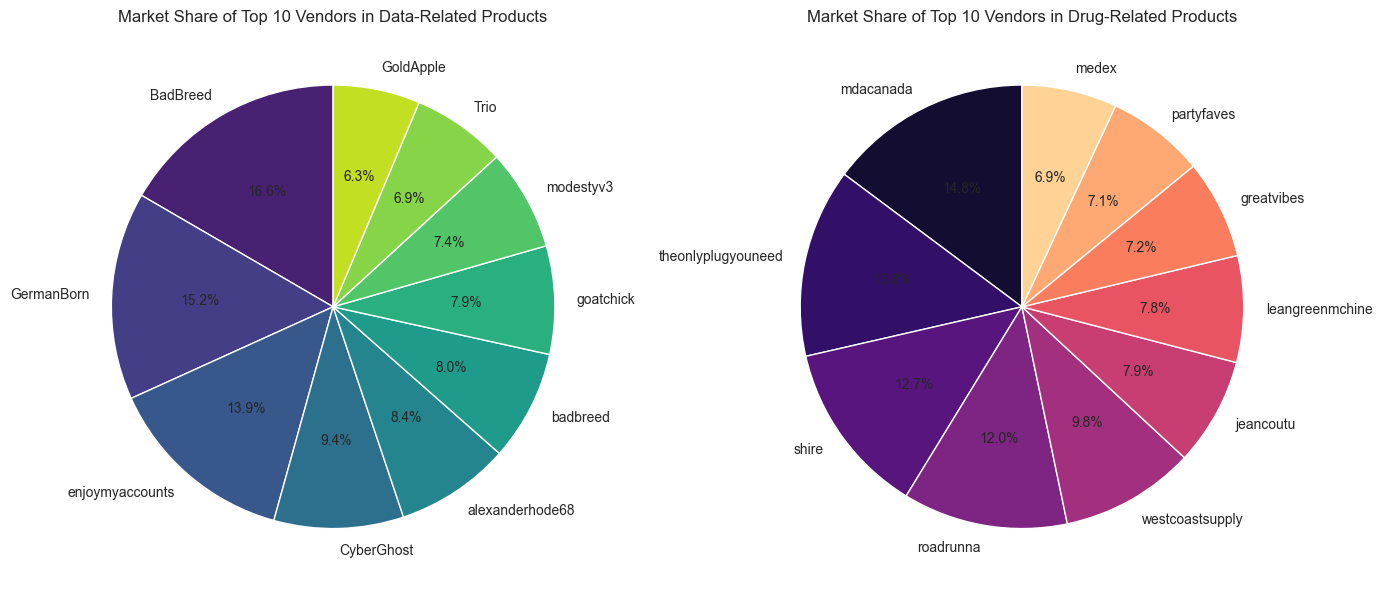

(vendor
 BadBreed           320
 GermanBorn         292
 enjoymyaccounts    268
 CyberGhost         182
 alexanderhode68    161
 badbreed           155
 goatchick          152
 modestyv3          142
 Trio               132
 GoldApple          122
 Name: count, dtype: int64,
 vendor
 mdacanada             160
 theonlyplugyouneed    149
 shire                 137
 roadrunna             130
 westcoastsupply       106
 jeancoutu              85
 leangreenmchine        84
 greatvibes             78
 partyfaves             77
 medex                  75
 Name: count, dtype: int64)

In [21]:
# Calculating market share for top 10 vendors in Data-Related and Drug-Related categories
top_vendors_data = product_df[product_df['main_business'] == 'Data']['vendor'].value_counts().head(10)
top_vendors_drugs = product_df[product_df['main_business'] == 'Drug']['vendor'].value_counts().head(10)

# Calculate percentages
total_data_products = top_vendors_data.sum()
total_drug_products = top_vendors_drugs.sum()
top_vendors_data_share = (top_vendors_data / total_data_products) * 100
top_vendors_drugs_share = (top_vendors_drugs / total_drug_products) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(top_vendors_data_share, labels=top_vendors_data.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', 10))
axes[0].set_title('Market Share of Top 10 Vendors in Data-Related Products')

axes[1].pie(top_vendors_drugs_share, labels=top_vendors_drugs.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('magma', 10))
axes[1].set_title('Market Share of Top 10 Vendors in Drug-Related Products')

plt.tight_layout()
plt.show()

(top_vendors_data, top_vendors_drugs)

## Reviews

In [22]:
review_df = pd.read_csv('data/reviews.csv')

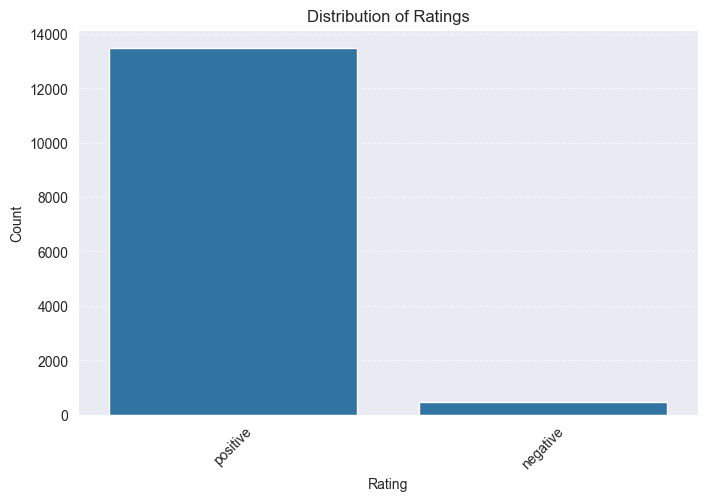

In [23]:
# Ensure the 'rating' column is treated as a categorical variable
review_df['rating'] = review_df['rating'].astype('category')

# Plotting the distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=review_df, order=review_df['rating'].value_counts().index)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

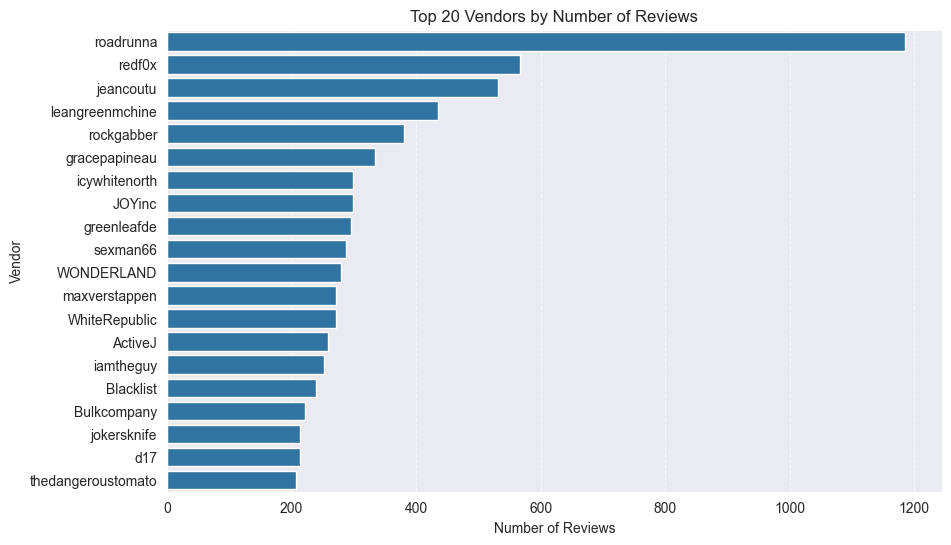

In [24]:
# Plotting the number of reviews per vendor
vendor_counts = review_df['vendor'].value_counts().head(20)  # Top 20 vendors
plt.figure(figsize=(10, 6))
sns.barplot(y=vendor_counts.index, x=vendor_counts.values, orient='h')
plt.title('Top 20 Vendors by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Vendor')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

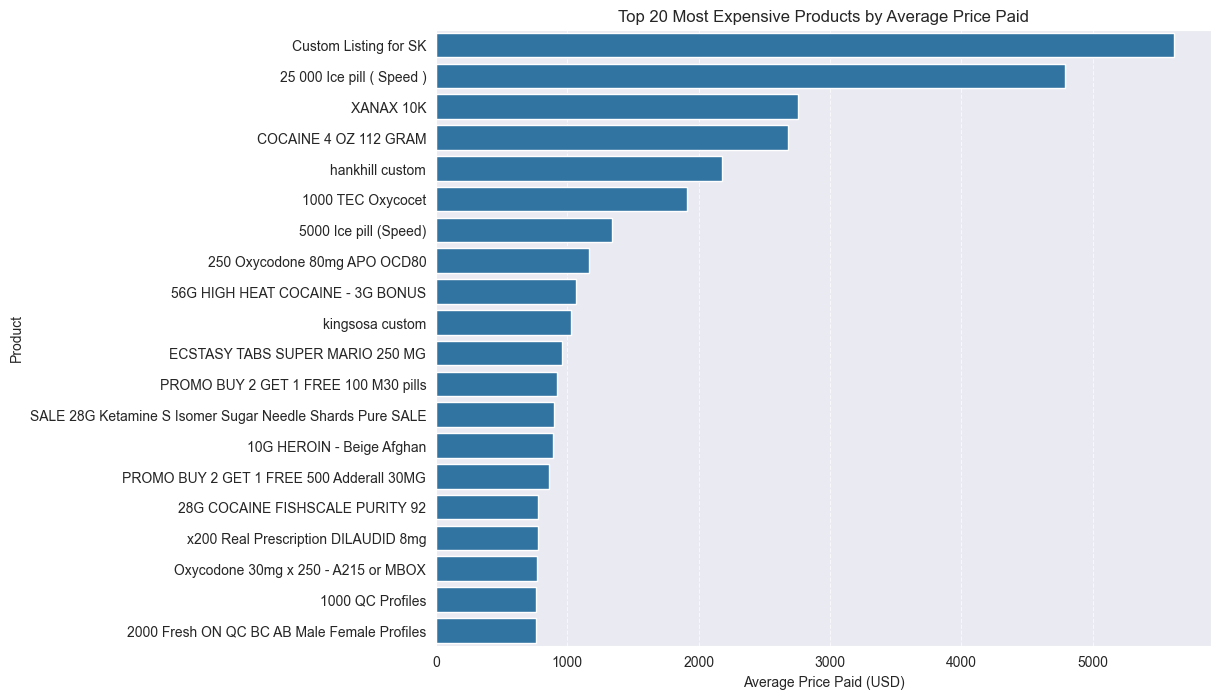

In [25]:
cleaned_data = review_df.dropna(subset=['price_paid_usd'])

# Grouping data by product and calculating the average price paid per product
average_price_per_product = cleaned_data.groupby('product')['price_paid_usd'].mean().sort_values(ascending=False).head(20)

# Plotting the average price paid per top 20 most expensive products
plt.figure(figsize=(10, 8))
sns.barplot(y=average_price_per_product.index, x=average_price_per_product.values, orient='h')
plt.title('Top 20 Most Expensive Products by Average Price Paid')
plt.xlabel('Average Price Paid (USD)')
plt.ylabel('Product')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

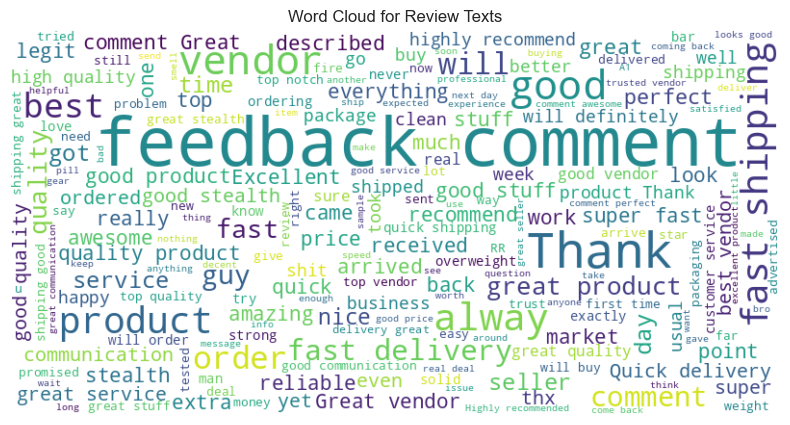

In [26]:
text = ' '.join(review for review in review_df['text'].dropna())

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.title('Word Cloud for Review Texts')
plt.show()

## Vendors

In [41]:
vendor_df = pd.read_csv('data/vendors.csv')

In [42]:
vendor_df

name                                         about_text  \
0           ausnarcoslord              Our Goal is to satisfied our clients.   
1                 ActiveJ  ==============================================...   
2                Broker01  Good seller $_$\n\nOnly fair deals\nDiscounts ...   
3                  Vamino  WELCOME TO VAMINO's WORLD..THE BEST YOU CAN FI...   
4                pinkcard  A cordial greeting friend, if you are here it ...   
..                    ...                                                ...   
439  thatguyfromtheblock7  WELCOME TO OUR STORE\nWe are bilangual FR and ...   
440               skyshin  A long time ago I worked for the telephone com...   
441            thebtcteam  The original thebitcointeam from canadahq and ...   
442               drgreen  Hello everyone , i am here to provide you the ...   
443              realeyez  RealEyez Official\n\n-------------------------...   

     review_count marketplace  review_count_normalized  
0              10       nexus                 0.001186  
1             211       nexus                 0.025018  
2               4       nexus                 0.000474  
3               2       nexus                 0.000237  
4               4       nexus                 0.000474  
..            ...         ...                      ...  
439             0  WeTheNorth                 0.000000  
440             0  WeTheNorth                 0.000000  
441             0  WeTheNorth                 0.000000  
442             0  WeTheNorth                 0.000000  
443             0  WeTheNorth                 0.000000  

[444 rows x 5 columns]

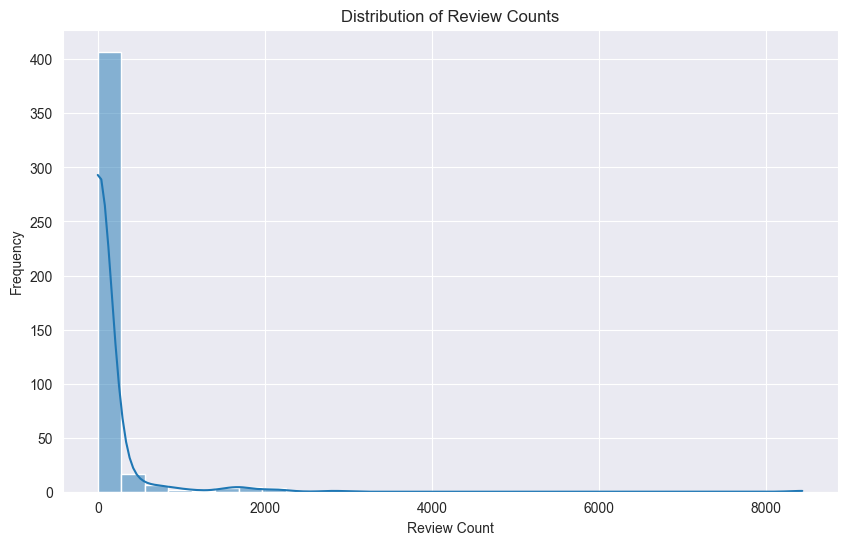

In [28]:
# Distribution of review counts
plt.figure(figsize=(10, 6))
sns.histplot(vendor_df['review_count'], bins=30, kde=True)
plt.title('Distribution of Review Counts')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.grid(True)

In [29]:
marketplace_counts = vendor_df['marketplace'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=marketplace_counts.index, y=marketplace_counts.values)
plt.title('Number of Vendors per Marketplace')
plt.xlabel('Marketplace')
plt.ylabel('Number of Vendors')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [30]:
about_text_combined = ' '.join(text for text in vendor_df['about_text'].dropna())

# Generate a word cloud image for the about_text
wordcloud_about = WordCloud(width=800, height=400, background_color='white').generate(about_text_combined)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_about, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.title('Word Cloud for Vendor About Texts')
plt.show()